- https://arxiv.org/pdf/1505.05424.pdf (Bayes by Backprop)
- https://arxiv.org/pdf/1802.02538.pdf (Yes but did it work?)
- http://discourse.mc-stan.org/t/using-the-psis-statistics-to-check-variational-inference-used-for-bnns/3534 (Stan PSIS discussion)
- https://cran.r-project.org/web/packages/loo/loo.pdf (loo package implementing the PSIS diagonstics)
- https://github.com/zackchase/mxnet-the-straight-dope/blob/master/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.ipynb (tutorial on which this notebook is based)
 

In [1]:
from __future__ import print_function
import collections
import mxnet as mx
import numpy as np
from mxnet import nd, autograd
from matplotlib import pyplot as plt

In [2]:
config = {
    "num_hidden_layers": 2,
    "num_hidden_units": 400, 
    "batch_size": 128,
    "epochs": 10,
    "learning_rate": 0.001,
    "num_samples": 1,
    "pi": 0.25,
    "sigma_p": 1.0,
    "sigma_p1": 0.75,
    "sigma_p2": 0.1,
}

In [3]:
ctx = mx.cpu()


In [4]:
def transform(data, label):
    return data.astype(np.float32)/126.0, label.astype(np.float32)

mnist = mx.test_utils.get_mnist()
num_inputs = 784
num_outputs = 10
batch_size = config['batch_size']

train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

num_train = sum([batch_size for i in train_data])
num_batches = num_train / batch_size
eval_data =  mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                      num_train, shuffle=False)

In [5]:
def relu(X):
    return nd.maximum(X, nd.zeros_like(X))


In [6]:
num_layers = config['num_hidden_layers']

# define function for evaluating MLP
def net(X, layer_params):
    layer_input = X
    for i in range(len(layer_params) // 2 - 2):
        h_linear = nd.dot(layer_input, layer_params[2*i]) + layer_params[2*i + 1]
        layer_input = relu(h_linear)
    # last layer without ReLU
    output = nd.dot(layer_input, layer_params[-2]) + layer_params[-1]
    return output

# define network weight shapes
layer_param_shapes = []
num_hidden = config['num_hidden_units']
for i in range(num_layers + 1):
    if i == 0: # input layer
        W_shape = (num_inputs, num_hidden)
        b_shape = (num_hidden,)  
    elif i == num_layers: # last layer
        W_shape = (num_hidden, num_outputs)
        b_shape = (num_outputs,)
    else: # hidden layers
        W_shape = (num_hidden, num_hidden)
        b_shape = (num_hidden,)
    layer_param_shapes.extend([W_shape, b_shape])

In [7]:
def log_softmax_likelihood(yhat_linear, y):
    return nd.nansum(y * nd.log_softmax(yhat_linear), axis=0, exclude=True)

In [8]:
LOG2PI = np.log(2.0 * np.pi)

def log_gaussian(x, mu, sigma):
    return -0.5 * LOG2PI - nd.log(sigma) - (x - mu) ** 2 / (2 * sigma ** 2)

def gaussian_prior(x):
    sigma_p = nd.array([config['sigma_p']], ctx=ctx)
    
    return nd.sum(log_gaussian(x, 0., sigma_p))

In [9]:
def gaussian(x, mu, sigma):
    scaling = 1.0 / nd.sqrt(2.0 * np.pi * (sigma ** 2))
    bell = nd.exp(- (x - mu) ** 2 / (2.0 * sigma ** 2))
    
    return scaling * bell

def scale_mixture_prior(x):
    sigma_p1 = nd.array([config['sigma_p1']], ctx=ctx)
    sigma_p2 = nd.array([config['sigma_p2']], ctx=ctx)
    pi = config['pi']
    
    first_gaussian = pi * gaussian(x, 0., sigma_p1)
    second_gaussian = (1 - pi) * gaussian(x, 0., sigma_p2)
    
    return nd.log(first_gaussian + second_gaussian)

In [10]:
def combined_loss(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood):
    
    # Calculate data likelihood
    log_likelihood_sum = nd.sum(log_likelihood(output, label_one_hot))
    
    # Calculate prior
    log_prior_sum = sum([nd.sum(log_prior(param)) for param in params])

    # Calculate variational posterior
    tmp0 = [log_gaussian(params[i], mus[i], sigmas[i]) for i in range(len(params))]
    tmp = [nd.sum(t) for t in tmp0]
    log_var_posterior_sum = sum(tmp)
    # Calculate total loss
    return 1.0 / num_batches * (log_var_posterior_sum - log_prior_sum) - log_likelihood_sum


In [11]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad


In [12]:
def evaluate_accuracy(data_iterator, net, layer_params):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        output = net(data, layer_params)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [13]:
weight_scale = .1
rho_offset = -3

# initialize variational parameters; mean and variance for each weight
mus = []
rhos = []
    
for shape in layer_param_shapes:
    mu = nd.random_normal(shape=shape, ctx=ctx, scale=weight_scale)
    rho = rho_offset + nd.zeros(shape=shape, ctx=ctx)
    mus.append(mu)
    rhos.append(rho)

variational_params = mus + rhos

In [14]:
for param in variational_params:
    param.attach_grad()

In [15]:
def sample_epsilons(param_shapes):
    epsilons = [nd.random_normal(shape=shape, loc=0., scale=1.0, ctx=ctx) for shape in param_shapes]
    return epsilons

In [16]:
def softplus(x):
    return nd.log(1. + nd.exp(x))

def transform_rhos(rhos):
    return [softplus(rho) for rho in rhos]

In [17]:
def transform_gaussian_samples(mus, sigmas, epsilons):
    samples = []
    for j in range(len(mus)):
        samples.append(mus[j] + sigmas[j] * epsilons[j])
    return samples

Epoch 0. Loss: 2626.284965, Train_acc 0.942233, Test_acc 0.9391
Epoch 1. Loss: 2606.47602121, Train_acc 0.9587, Test_acc 0.9535
Epoch 2. Loss: 2600.19366146, Train_acc 0.970417, Test_acc 0.9651
Epoch 3. Loss: 2596.81727694, Train_acc 0.975083, Test_acc 0.9696
Epoch 4. Loss: 2593.08268018, Train_acc 0.977767, Test_acc 0.9692
Epoch 5. Loss: 2590.29157419, Train_acc 0.9802, Test_acc 0.9727
Epoch 6. Loss: 2587.68317794, Train_acc 0.983017, Test_acc 0.9743
Epoch 7. Loss: 2585.40092067, Train_acc 0.984883, Test_acc 0.9753
Epoch 8. Loss: 2584.46871272, Train_acc 0.985617, Test_acc 0.9761
Epoch 9. Loss: 2582.14834094, Train_acc 0.987017, Test_acc 0.9753


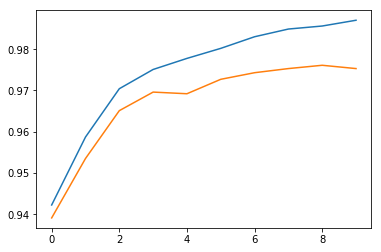

In [18]:
epochs = config['epochs']
learning_rate = config['learning_rate']
smoothing_constant = .01
train_acc = []
test_acc = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        
        with autograd.record():
            # sample epsilons from standard normal
            epsilons = sample_epsilons(layer_param_shapes)
            
            # compute softplus for variance
            sigmas = transform_rhos(rhos)

            # obtain a sample from q(w|theta) by transforming the epsilons
            layer_params = transform_gaussian_samples(mus, sigmas, epsilons)
            
            # forward-propagate the batch
            output = net(data, layer_params)
            
            # calculate the loss
            loss = combined_loss(output, label_one_hot, layer_params, mus, sigmas, gaussian_prior, log_softmax_likelihood)
            
        # backpropagate for gradient calculation
        loss.backward()
        
        # apply stochastic gradient descent to variational parameters
        SGD(variational_params, learning_rate)
        
        # calculate moving loss for monitoring convergence
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

        
    test_accuracy = evaluate_accuracy(test_data, net, mus)
    train_accuracy = evaluate_accuracy(train_data, net, mus)
    train_acc.append(np.asscalar(train_accuracy))
    test_acc.append(np.asscalar(test_accuracy))
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, moving_loss, train_accuracy, test_accuracy))
    
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

In [19]:
def true_posterior(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood):
    
    # Calculate data likelihood
    log_likelihood_sum = nd.sum(log_likelihood(output, label_one_hot))
    
    # Calculate prior
    log_prior_sum = sum([nd.sum(log_prior(param)) for param in params])

  
    return log_prior_sum +  log_likelihood_sum
############################
def vi_posterior(output, label_one_hot, params, mus, sigmas, log_prior, log_likelihood):
    
   
    # Calculate variational posterior
    tmp0 = [log_gaussian(params[i], mus[i], sigmas[i]) for i in range(len(params))]
    tmp = [nd.sum(t) for t in tmp0]
    log_var_posterior_sum = sum(tmp)
    # Calculate total loss
    return log_var_posterior_sum


In [20]:
epochs = 1000
tposts = []
viposts = []

for e in range(epochs):
    for i, (data, label) in enumerate(eval_data):
        data = data.as_in_context(ctx).reshape((-1, 784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        
      
        # sample epsilons from standard normal
        epsilons = sample_epsilons(layer_param_shapes)
            
        # compute softplus for variance
        sigmas = transform_rhos(rhos)

        # obtain a sample from q(w|theta) by transforming the epsilons
        layer_params = transform_gaussian_samples(mus, sigmas, epsilons)
            
        # forward-propagate the batch
        output = net(data, layer_params)
        
        tposts.append(true_posterior(output, label_one_hot, layer_params, mus, sigmas, gaussian_prior, log_softmax_likelihood))
        viposts.append(vi_posterior(output, label_one_hot, layer_params, mus, sigmas, gaussian_prior, log_softmax_likelihood))
        print(e, tposts[-1], viposts[-1], tposts[-1]-viposts[-1])

0 
[-443810.65625]
<NDArray 1 @cpu(0)> 
[ 763623.25]
<NDArray 1 @cpu(0)> 
[-1207433.875]
<NDArray 1 @cpu(0)>
1 
[-443706.4375]
<NDArray 1 @cpu(0)> 
[ 763740.75]
<NDArray 1 @cpu(0)> 
[-1207447.25]
<NDArray 1 @cpu(0)>
2 
[-443757.875]
<NDArray 1 @cpu(0)> 
[ 763650.0625]
<NDArray 1 @cpu(0)> 
[-1207408.]
<NDArray 1 @cpu(0)>
3 
[-443732.625]
<NDArray 1 @cpu(0)> 
[ 762983.0625]
<NDArray 1 @cpu(0)> 
[-1206715.75]
<NDArray 1 @cpu(0)>
4 
[-443837.4375]
<NDArray 1 @cpu(0)> 
[ 763074.8125]
<NDArray 1 @cpu(0)> 
[-1206912.25]
<NDArray 1 @cpu(0)>
5 
[-443740.1875]
<NDArray 1 @cpu(0)> 
[ 762924.75]
<NDArray 1 @cpu(0)> 
[-1206665.]
<NDArray 1 @cpu(0)>
6 
[-443718.5]
<NDArray 1 @cpu(0)> 
[ 763616.6875]
<NDArray 1 @cpu(0)> 
[-1207335.25]
<NDArray 1 @cpu(0)>
7 
[-443660.6875]
<NDArray 1 @cpu(0)> 
[ 763620.875]
<NDArray 1 @cpu(0)> 
[-1207281.5]
<NDArray 1 @cpu(0)>
8 
[-443749.1875]
<NDArray 1 @cpu(0)> 
[ 763445.4375]
<NDArray 1 @cpu(0)> 
[-1207194.625]
<NDArray 1 @cpu(0)>
9 
[-443780.78125]
<NDArray 1 @cp

76 
[-443825.75]
<NDArray 1 @cpu(0)> 
[ 764293.8125]
<NDArray 1 @cpu(0)> 
[-1208119.5]
<NDArray 1 @cpu(0)>
77 
[-443754.5625]
<NDArray 1 @cpu(0)> 
[ 763446.]
<NDArray 1 @cpu(0)> 
[-1207200.5]
<NDArray 1 @cpu(0)>
78 
[-443832.15625]
<NDArray 1 @cpu(0)> 
[ 762950.375]
<NDArray 1 @cpu(0)> 
[-1206782.5]
<NDArray 1 @cpu(0)>
79 
[-443641.65625]
<NDArray 1 @cpu(0)> 
[ 763773.9375]
<NDArray 1 @cpu(0)> 
[-1207415.625]
<NDArray 1 @cpu(0)>
80 
[-443706.4375]
<NDArray 1 @cpu(0)> 
[ 763547.875]
<NDArray 1 @cpu(0)> 
[-1207254.25]
<NDArray 1 @cpu(0)>
81 
[-443767.21875]
<NDArray 1 @cpu(0)> 
[ 763541.3125]
<NDArray 1 @cpu(0)> 
[-1207308.5]
<NDArray 1 @cpu(0)>
82 
[-443633.8125]
<NDArray 1 @cpu(0)> 
[ 764166.0625]
<NDArray 1 @cpu(0)> 
[-1207799.875]
<NDArray 1 @cpu(0)>
83 
[-443717.125]
<NDArray 1 @cpu(0)> 
[ 762732.]
<NDArray 1 @cpu(0)> 
[-1206449.125]
<NDArray 1 @cpu(0)>
84 
[-443677.09375]
<NDArray 1 @cpu(0)> 
[ 763539.0625]
<NDArray 1 @cpu(0)> 
[-1207216.125]
<NDArray 1 @cpu(0)>
85 
[-443728.0625]


151 
[-443708.34375]
<NDArray 1 @cpu(0)> 
[ 763681.125]
<NDArray 1 @cpu(0)> 
[-1207389.5]
<NDArray 1 @cpu(0)>
152 
[-443670.5625]
<NDArray 1 @cpu(0)> 
[ 763174.625]
<NDArray 1 @cpu(0)> 
[-1206845.25]
<NDArray 1 @cpu(0)>
153 
[-443675.40625]
<NDArray 1 @cpu(0)> 
[ 764325.8125]
<NDArray 1 @cpu(0)> 
[-1208001.25]
<NDArray 1 @cpu(0)>
154 
[-443619.28125]
<NDArray 1 @cpu(0)> 
[ 762612.5]
<NDArray 1 @cpu(0)> 
[-1206231.75]
<NDArray 1 @cpu(0)>
155 
[-443707.1875]
<NDArray 1 @cpu(0)> 
[ 763730.1875]
<NDArray 1 @cpu(0)> 
[-1207437.375]
<NDArray 1 @cpu(0)>
156 
[-443657.78125]
<NDArray 1 @cpu(0)> 
[ 764140.8125]
<NDArray 1 @cpu(0)> 
[-1207798.625]
<NDArray 1 @cpu(0)>
157 
[-443811.96875]
<NDArray 1 @cpu(0)> 
[ 763421.1875]
<NDArray 1 @cpu(0)> 
[-1207233.125]
<NDArray 1 @cpu(0)>
158 
[-443694.28125]
<NDArray 1 @cpu(0)> 
[ 763956.5]
<NDArray 1 @cpu(0)> 
[-1207650.75]
<NDArray 1 @cpu(0)>
159 
[-443788.8125]
<NDArray 1 @cpu(0)> 
[ 763336.8125]
<NDArray 1 @cpu(0)> 
[-1207125.625]
<NDArray 1 @cpu(0)>


226 
[-443720.59375]
<NDArray 1 @cpu(0)> 
[ 763083.9375]
<NDArray 1 @cpu(0)> 
[-1206804.5]
<NDArray 1 @cpu(0)>
227 
[-443716.65625]
<NDArray 1 @cpu(0)> 
[ 763441.375]
<NDArray 1 @cpu(0)> 
[-1207158.]
<NDArray 1 @cpu(0)>
228 
[-443726.75]
<NDArray 1 @cpu(0)> 
[ 763581.]
<NDArray 1 @cpu(0)> 
[-1207307.75]
<NDArray 1 @cpu(0)>
229 
[-443748.375]
<NDArray 1 @cpu(0)> 
[ 763087.25]
<NDArray 1 @cpu(0)> 
[-1206835.625]
<NDArray 1 @cpu(0)>
230 
[-443800.75]
<NDArray 1 @cpu(0)> 
[ 763390.6875]
<NDArray 1 @cpu(0)> 
[-1207191.5]
<NDArray 1 @cpu(0)>
231 
[-443658.1875]
<NDArray 1 @cpu(0)> 
[ 763109.375]
<NDArray 1 @cpu(0)> 
[-1206767.5]
<NDArray 1 @cpu(0)>
232 
[-443781.125]
<NDArray 1 @cpu(0)> 
[ 764005.5]
<NDArray 1 @cpu(0)> 
[-1207786.625]
<NDArray 1 @cpu(0)>
233 
[-443741.875]
<NDArray 1 @cpu(0)> 
[ 763832.6875]
<NDArray 1 @cpu(0)> 
[-1207574.5]
<NDArray 1 @cpu(0)>
234 
[-443670.5]
<NDArray 1 @cpu(0)> 
[ 763421.0625]
<NDArray 1 @cpu(0)> 
[-1207091.5]
<NDArray 1 @cpu(0)>
235 
[-443748.9375]
<NDAr

301 
[-443769.5]
<NDArray 1 @cpu(0)> 
[ 763101.6875]
<NDArray 1 @cpu(0)> 
[-1206871.25]
<NDArray 1 @cpu(0)>
302 
[-443784.65625]
<NDArray 1 @cpu(0)> 
[ 763904.3125]
<NDArray 1 @cpu(0)> 
[-1207689.]
<NDArray 1 @cpu(0)>
303 
[-443787.21875]
<NDArray 1 @cpu(0)> 
[ 763791.]
<NDArray 1 @cpu(0)> 
[-1207578.25]
<NDArray 1 @cpu(0)>
304 
[-443748.5]
<NDArray 1 @cpu(0)> 
[ 763947.125]
<NDArray 1 @cpu(0)> 
[-1207695.625]
<NDArray 1 @cpu(0)>
305 
[-443757.09375]
<NDArray 1 @cpu(0)> 
[ 763315.9375]
<NDArray 1 @cpu(0)> 
[-1207073.]
<NDArray 1 @cpu(0)>
306 
[-443692.03125]
<NDArray 1 @cpu(0)> 
[ 762673.0625]
<NDArray 1 @cpu(0)> 
[-1206365.125]
<NDArray 1 @cpu(0)>
307 
[-443824.5625]
<NDArray 1 @cpu(0)> 
[ 763780.8125]
<NDArray 1 @cpu(0)> 
[-1207605.375]
<NDArray 1 @cpu(0)>
308 
[-443727.4375]
<NDArray 1 @cpu(0)> 
[ 762715.4375]
<NDArray 1 @cpu(0)> 
[-1206442.875]
<NDArray 1 @cpu(0)>
309 
[-443800.5]
<NDArray 1 @cpu(0)> 
[ 762806.625]
<NDArray 1 @cpu(0)> 
[-1206607.125]
<NDArray 1 @cpu(0)>
310 
[-4437

376 
[-443656.96875]
<NDArray 1 @cpu(0)> 
[ 763673.875]
<NDArray 1 @cpu(0)> 
[-1207330.875]
<NDArray 1 @cpu(0)>
377 
[-443861.40625]
<NDArray 1 @cpu(0)> 
[ 763221.875]
<NDArray 1 @cpu(0)> 
[-1207083.25]
<NDArray 1 @cpu(0)>
378 
[-443596.8125]
<NDArray 1 @cpu(0)> 
[ 763067.1875]
<NDArray 1 @cpu(0)> 
[-1206664.]
<NDArray 1 @cpu(0)>
379 
[-443785.15625]
<NDArray 1 @cpu(0)> 
[ 763910.4375]
<NDArray 1 @cpu(0)> 
[-1207695.625]
<NDArray 1 @cpu(0)>
380 
[-443883.75]
<NDArray 1 @cpu(0)> 
[ 763336.125]
<NDArray 1 @cpu(0)> 
[-1207219.875]
<NDArray 1 @cpu(0)>
381 
[-443748.5]
<NDArray 1 @cpu(0)> 
[ 763864.1875]
<NDArray 1 @cpu(0)> 
[-1207612.75]
<NDArray 1 @cpu(0)>
382 
[-443695.5]
<NDArray 1 @cpu(0)> 
[ 763365.8125]
<NDArray 1 @cpu(0)> 
[-1207061.25]
<NDArray 1 @cpu(0)>
383 
[-443769.5]
<NDArray 1 @cpu(0)> 
[ 763555.25]
<NDArray 1 @cpu(0)> 
[-1207324.75]
<NDArray 1 @cpu(0)>
384 
[-443906.84375]
<NDArray 1 @cpu(0)> 
[ 764093.5]
<NDArray 1 @cpu(0)> 
[-1208000.375]
<NDArray 1 @cpu(0)>
385 
[-443742.

451 
[-443670.125]
<NDArray 1 @cpu(0)> 
[ 763655.4375]
<NDArray 1 @cpu(0)> 
[-1207325.5]
<NDArray 1 @cpu(0)>
452 
[-443755.65625]
<NDArray 1 @cpu(0)> 
[ 763911.5]
<NDArray 1 @cpu(0)> 
[-1207667.125]
<NDArray 1 @cpu(0)>
453 
[-443667.25]
<NDArray 1 @cpu(0)> 
[ 763481.9375]
<NDArray 1 @cpu(0)> 
[-1207149.25]
<NDArray 1 @cpu(0)>
454 
[-443924.125]
<NDArray 1 @cpu(0)> 
[ 761956.75]
<NDArray 1 @cpu(0)> 
[-1205880.875]
<NDArray 1 @cpu(0)>
455 
[-443681.25]
<NDArray 1 @cpu(0)> 
[ 763213.375]
<NDArray 1 @cpu(0)> 
[-1206894.625]
<NDArray 1 @cpu(0)>
456 
[-443833.09375]
<NDArray 1 @cpu(0)> 
[ 763150.75]
<NDArray 1 @cpu(0)> 
[-1206983.875]
<NDArray 1 @cpu(0)>
457 
[-443758.84375]
<NDArray 1 @cpu(0)> 
[ 762762.875]
<NDArray 1 @cpu(0)> 
[-1206521.75]
<NDArray 1 @cpu(0)>
458 
[-443724.875]
<NDArray 1 @cpu(0)> 
[ 762688.]
<NDArray 1 @cpu(0)> 
[-1206412.875]
<NDArray 1 @cpu(0)>
459 
[-443808.34375]
<NDArray 1 @cpu(0)> 
[ 762660.625]
<NDArray 1 @cpu(0)> 
[-1206469.]
<NDArray 1 @cpu(0)>
460 
[-443813.12

526 
[-443811.0625]
<NDArray 1 @cpu(0)> 
[ 762650.625]
<NDArray 1 @cpu(0)> 
[-1206461.75]
<NDArray 1 @cpu(0)>
527 
[-443699.71875]
<NDArray 1 @cpu(0)> 
[ 764326.875]
<NDArray 1 @cpu(0)> 
[-1208026.625]
<NDArray 1 @cpu(0)>
528 
[-443700.65625]
<NDArray 1 @cpu(0)> 
[ 763847.6875]
<NDArray 1 @cpu(0)> 
[-1207548.375]
<NDArray 1 @cpu(0)>
529 
[-443738.75]
<NDArray 1 @cpu(0)> 
[ 763422.6875]
<NDArray 1 @cpu(0)> 
[-1207161.5]
<NDArray 1 @cpu(0)>
530 
[-443762.34375]
<NDArray 1 @cpu(0)> 
[ 764837.6875]
<NDArray 1 @cpu(0)> 
[-1208600.]
<NDArray 1 @cpu(0)>
531 
[-443808.90625]
<NDArray 1 @cpu(0)> 
[ 762977.]
<NDArray 1 @cpu(0)> 
[-1206785.875]
<NDArray 1 @cpu(0)>
532 
[-443849.84375]
<NDArray 1 @cpu(0)> 
[ 763262.75]
<NDArray 1 @cpu(0)> 
[-1207112.625]
<NDArray 1 @cpu(0)>
533 
[-443829.75]
<NDArray 1 @cpu(0)> 
[ 763874.25]
<NDArray 1 @cpu(0)> 
[-1207704.]
<NDArray 1 @cpu(0)>
534 
[-443759.21875]
<NDArray 1 @cpu(0)> 
[ 763511.875]
<NDArray 1 @cpu(0)> 
[-1207271.125]
<NDArray 1 @cpu(0)>
535 
[-443

601 
[-443733.40625]
<NDArray 1 @cpu(0)> 
[ 763879.5625]
<NDArray 1 @cpu(0)> 
[-1207613.]
<NDArray 1 @cpu(0)>
602 
[-443783.84375]
<NDArray 1 @cpu(0)> 
[ 763782.375]
<NDArray 1 @cpu(0)> 
[-1207566.25]
<NDArray 1 @cpu(0)>
603 
[-443777.]
<NDArray 1 @cpu(0)> 
[ 763509.625]
<NDArray 1 @cpu(0)> 
[-1207286.625]
<NDArray 1 @cpu(0)>
604 
[-443921.09375]
<NDArray 1 @cpu(0)> 
[ 763695.375]
<NDArray 1 @cpu(0)> 
[-1207616.5]
<NDArray 1 @cpu(0)>
605 
[-443829.90625]
<NDArray 1 @cpu(0)> 
[ 763794.3125]
<NDArray 1 @cpu(0)> 
[-1207624.25]
<NDArray 1 @cpu(0)>
606 
[-443763.5]
<NDArray 1 @cpu(0)> 
[ 763606.375]
<NDArray 1 @cpu(0)> 
[-1207369.875]
<NDArray 1 @cpu(0)>
607 
[-443800.75]
<NDArray 1 @cpu(0)> 
[ 763939.6875]
<NDArray 1 @cpu(0)> 
[-1207740.5]
<NDArray 1 @cpu(0)>
608 
[-444063.21875]
<NDArray 1 @cpu(0)> 
[ 763863.625]
<NDArray 1 @cpu(0)> 
[-1207926.875]
<NDArray 1 @cpu(0)>
609 
[-443735.875]
<NDArray 1 @cpu(0)> 
[ 763757.875]
<NDArray 1 @cpu(0)> 
[-1207493.75]
<NDArray 1 @cpu(0)>
610 
[-443723

676 
[-443707.8125]
<NDArray 1 @cpu(0)> 
[ 763742.9375]
<NDArray 1 @cpu(0)> 
[-1207450.75]
<NDArray 1 @cpu(0)>
677 
[-443685.84375]
<NDArray 1 @cpu(0)> 
[ 763596.8125]
<NDArray 1 @cpu(0)> 
[-1207282.625]
<NDArray 1 @cpu(0)>
678 
[-443705.125]
<NDArray 1 @cpu(0)> 
[ 764368.5625]
<NDArray 1 @cpu(0)> 
[-1208073.75]
<NDArray 1 @cpu(0)>
679 
[-443785.875]
<NDArray 1 @cpu(0)> 
[ 764266.]
<NDArray 1 @cpu(0)> 
[-1208051.875]
<NDArray 1 @cpu(0)>
680 
[-443853.625]
<NDArray 1 @cpu(0)> 
[ 763956.375]
<NDArray 1 @cpu(0)> 
[-1207810.]
<NDArray 1 @cpu(0)>
681 
[-443796.84375]
<NDArray 1 @cpu(0)> 
[ 763204.8125]
<NDArray 1 @cpu(0)> 
[-1207001.625]
<NDArray 1 @cpu(0)>
682 
[-443687.6875]
<NDArray 1 @cpu(0)> 
[ 763204.5625]
<NDArray 1 @cpu(0)> 
[-1206892.25]
<NDArray 1 @cpu(0)>
683 
[-443755.0625]
<NDArray 1 @cpu(0)> 
[ 763846.625]
<NDArray 1 @cpu(0)> 
[-1207601.75]
<NDArray 1 @cpu(0)>
684 
[-443712.375]
<NDArray 1 @cpu(0)> 
[ 763921.5]
<NDArray 1 @cpu(0)> 
[-1207633.875]
<NDArray 1 @cpu(0)>
685 
[-443

751 
[-443801.84375]
<NDArray 1 @cpu(0)> 
[ 763452.5625]
<NDArray 1 @cpu(0)> 
[-1207254.375]
<NDArray 1 @cpu(0)>
752 
[-443802.625]
<NDArray 1 @cpu(0)> 
[ 762958.875]
<NDArray 1 @cpu(0)> 
[-1206761.5]
<NDArray 1 @cpu(0)>
753 
[-443705.875]
<NDArray 1 @cpu(0)> 
[ 763479.125]
<NDArray 1 @cpu(0)> 
[-1207185.]
<NDArray 1 @cpu(0)>
754 
[-443792.]
<NDArray 1 @cpu(0)> 
[ 763232.4375]
<NDArray 1 @cpu(0)> 
[-1207024.5]
<NDArray 1 @cpu(0)>
755 
[-443752.125]
<NDArray 1 @cpu(0)> 
[ 763411.5]
<NDArray 1 @cpu(0)> 
[-1207163.625]
<NDArray 1 @cpu(0)>
756 
[-443698.59375]
<NDArray 1 @cpu(0)> 
[ 763057.375]
<NDArray 1 @cpu(0)> 
[-1206756.]
<NDArray 1 @cpu(0)>
757 
[-443707.125]
<NDArray 1 @cpu(0)> 
[ 763653.9375]
<NDArray 1 @cpu(0)> 
[-1207361.]
<NDArray 1 @cpu(0)>
758 
[-443817.34375]
<NDArray 1 @cpu(0)> 
[ 763550.625]
<NDArray 1 @cpu(0)> 
[-1207368.]
<NDArray 1 @cpu(0)>
759 
[-443869.84375]
<NDArray 1 @cpu(0)> 
[ 763578.9375]
<NDArray 1 @cpu(0)> 
[-1207448.75]
<NDArray 1 @cpu(0)>
760 
[-443919.84375]

826 
[-443661.03125]
<NDArray 1 @cpu(0)> 
[ 763065.]
<NDArray 1 @cpu(0)> 
[-1206726.]
<NDArray 1 @cpu(0)>
827 
[-443867.03125]
<NDArray 1 @cpu(0)> 
[ 763137.25]
<NDArray 1 @cpu(0)> 
[-1207004.25]
<NDArray 1 @cpu(0)>
828 
[-443699.09375]
<NDArray 1 @cpu(0)> 
[ 764634.875]
<NDArray 1 @cpu(0)> 
[-1208334.]
<NDArray 1 @cpu(0)>
829 
[-443715.]
<NDArray 1 @cpu(0)> 
[ 763131.625]
<NDArray 1 @cpu(0)> 
[-1206846.625]
<NDArray 1 @cpu(0)>
830 
[-443748.6875]
<NDArray 1 @cpu(0)> 
[ 763670.625]
<NDArray 1 @cpu(0)> 
[-1207419.25]
<NDArray 1 @cpu(0)>
831 
[-443911.78125]
<NDArray 1 @cpu(0)> 
[ 763761.5]
<NDArray 1 @cpu(0)> 
[-1207673.25]
<NDArray 1 @cpu(0)>
832 
[-443830.40625]
<NDArray 1 @cpu(0)> 
[ 763938.]
<NDArray 1 @cpu(0)> 
[-1207768.375]
<NDArray 1 @cpu(0)>
833 
[-443783.15625]
<NDArray 1 @cpu(0)> 
[ 763584.4375]
<NDArray 1 @cpu(0)> 
[-1207367.625]
<NDArray 1 @cpu(0)>
834 
[-443777.84375]
<NDArray 1 @cpu(0)> 
[ 764030.5]
<NDArray 1 @cpu(0)> 
[-1207808.375]
<NDArray 1 @cpu(0)>
835 
[-443943.812

901 
[-443672.125]
<NDArray 1 @cpu(0)> 
[ 764271.5]
<NDArray 1 @cpu(0)> 
[-1207943.625]
<NDArray 1 @cpu(0)>
902 
[-443826.1875]
<NDArray 1 @cpu(0)> 
[ 763775.875]
<NDArray 1 @cpu(0)> 
[-1207602.]
<NDArray 1 @cpu(0)>
903 
[-443707.84375]
<NDArray 1 @cpu(0)> 
[ 763443.875]
<NDArray 1 @cpu(0)> 
[-1207151.75]
<NDArray 1 @cpu(0)>
904 
[-443777.28125]
<NDArray 1 @cpu(0)> 
[ 763514.3125]
<NDArray 1 @cpu(0)> 
[-1207291.625]
<NDArray 1 @cpu(0)>
905 
[-443740.9375]
<NDArray 1 @cpu(0)> 
[ 764298.0625]
<NDArray 1 @cpu(0)> 
[-1208039.]
<NDArray 1 @cpu(0)>
906 
[-443769.3125]
<NDArray 1 @cpu(0)> 
[ 763009.125]
<NDArray 1 @cpu(0)> 
[-1206778.5]
<NDArray 1 @cpu(0)>
907 
[-443684.65625]
<NDArray 1 @cpu(0)> 
[ 763186.5625]
<NDArray 1 @cpu(0)> 
[-1206871.25]
<NDArray 1 @cpu(0)>
908 
[-443736.46875]
<NDArray 1 @cpu(0)> 
[ 763177.0625]
<NDArray 1 @cpu(0)> 
[-1206913.5]
<NDArray 1 @cpu(0)>
909 
[-443733.0625]
<NDArray 1 @cpu(0)> 
[ 763635.]
<NDArray 1 @cpu(0)> 
[-1207368.]
<NDArray 1 @cpu(0)>
910 
[-443697.

976 
[-443716.96875]
<NDArray 1 @cpu(0)> 
[ 764221.8125]
<NDArray 1 @cpu(0)> 
[-1207938.75]
<NDArray 1 @cpu(0)>
977 
[-443747.5625]
<NDArray 1 @cpu(0)> 
[ 763815.75]
<NDArray 1 @cpu(0)> 
[-1207563.25]
<NDArray 1 @cpu(0)>
978 
[-443825.75]
<NDArray 1 @cpu(0)> 
[ 763283.625]
<NDArray 1 @cpu(0)> 
[-1207109.375]
<NDArray 1 @cpu(0)>
979 
[-443695.15625]
<NDArray 1 @cpu(0)> 
[ 764020.375]
<NDArray 1 @cpu(0)> 
[-1207715.5]
<NDArray 1 @cpu(0)>
980 
[-443820.1875]
<NDArray 1 @cpu(0)> 
[ 762607.125]
<NDArray 1 @cpu(0)> 
[-1206427.25]
<NDArray 1 @cpu(0)>
981 
[-443757.65625]
<NDArray 1 @cpu(0)> 
[ 762397.6875]
<NDArray 1 @cpu(0)> 
[-1206155.375]
<NDArray 1 @cpu(0)>
982 
[-443684.96875]
<NDArray 1 @cpu(0)> 
[ 763919.375]
<NDArray 1 @cpu(0)> 
[-1207604.375]
<NDArray 1 @cpu(0)>
983 
[-443712.15625]
<NDArray 1 @cpu(0)> 
[ 764815.25]
<NDArray 1 @cpu(0)> 
[-1208527.375]
<NDArray 1 @cpu(0)>
984 
[-443844.90625]
<NDArray 1 @cpu(0)> 
[ 764144.3125]
<NDArray 1 @cpu(0)> 
[-1207989.25]
<NDArray 1 @cpu(0)>
98

In [22]:
tposts_v = np.asarray([t.asscalar() for t in tposts])
viposts_v = np.asarray([t.asscalar() for t in viposts])

In [23]:
lws = tposts_v - viposts_v

In [25]:
np.savetxt("/Users/eren/Desktop/lws_bnn.txt", lws)